In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib.font_manager import FontProperties

## Usage

This notebook is to visualize the output of `all_in_one_cifar10.py` 

In [2]:
OUTPUT = 'experiments/SENet18_ifgsm.csv'

df = pd.read_csv(OUTPUT)

In [3]:
def visualize_result(df):
    source_models = df.source_model.unique()
    target_models =  df.target_model.unique()
    attacks = df.fool_method.unique()
    metrics = ['acc_after_attack']
    for metric in metrics:

        for source_model in source_models:
            fig = plt.figure(figsize = [6*len(attacks), 4])
            shared_ax = None
            for i, attack in enumerate(attacks):

                if shared_ax == None:
                    shared_ax = plt.subplot(1,len(attacks),i+1)
                else:
                    plt.subplot(1,len(attacks),i+1, sharey=shared_ax)

                layer_indexs = df[df.source_model == source_model]['layer_index'].unique()[1:]
                layer_names = df[df.source_model == source_model]['layer_name'].unique()[1:]
                print(layer_names)
                for target_model in target_models:           
                    r = df[(df.source_model == source_model) & (df.target_model == target_model) & (df.fool_method == attack)]

                    fla = r[r.with_ILA].groupby('layer_index')
                    other = r[r.with_ILA == False]
                    xs = fla.layer_index.unique()
                    baseline = other[metric].mean()
                    fla_r = fla[metric].mean()
                    names = fla.layer_name.unique()
                    p = plt.plot(layer_indexs,  [baseline for i in xs], linestyle = '--', label = target_model)
                    plt.plot(fla_r, label =  target_model + " ILAP", color = p[0]._color)
                    if source_model != target_model and ((metric == 'fool_rate' and not(fla_r > baseline).any())or (metric == 'acc_after_attack' and not(fla_r < baseline).any())):
                        print("never perform absolutely better: " + source_model + " " + target_model)

                plt.ylim([0,75])
                plt.ylabel('Accuracy after Attack')
                plt.xlabel('Layer Index')
                fontP = FontProperties()
                fontP.set_size('small')
                
                plt.legend(ncol = 3, loc=2, prop=fontP)
            plt.savefig('experiments/layer_SENet18_ifgsm.png')
            plt.show()
    


['conv1' 'bn1' 'layer1' 'layer2' 'layer3' 'layer4' 'linear']


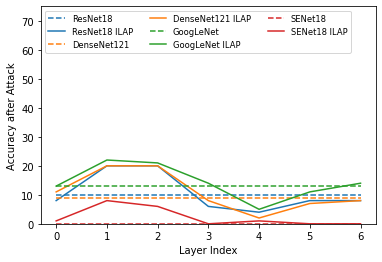

In [4]:
visualize_result(df)

In [5]:
# Original model accuracies
df.groupby(['source_model', 'target_model','fool_method'])['original_acc'].mean().reset_index()

,source_model,target_model,fool_method,original_acc
0,SENet18,DenseNet121,ifgsm,90.0
1,SENet18,GoogLeNet,ifgsm,92.0
2,SENet18,ResNet18,ifgsm,92.0
3,SENet18,SENet18,ifgsm,88.0


In [6]:
baseline = df[df.with_ILA == False].groupby(['source_model', 'target_model','fool_method'])['acc_after_attack'].mean().reset_index()
baseline

,source_model,target_model,fool_method,acc_after_attack
0,SENet18,DenseNet121,ifgsm,9.0
1,SENet18,GoogLeNet,ifgsm,13.0
2,SENet18,ResNet18,ifgsm,10.0
3,SENet18,SENet18,ifgsm,0.0


In [7]:
# ILA
q = df[(df.with_ILA == True)].groupby(['source_model', 'target_model','fool_method','layer_index'])['acc_after_attack'].mean().reset_index()
q

,source_model,target_model,fool_method,layer_index,acc_after_attack
0,SENet18,DenseNet121,ifgsm,0.0,11.0
1,SENet18,DenseNet121,ifgsm,1.0,20.0
2,SENet18,DenseNet121,ifgsm,2.0,20.0
3,SENet18,DenseNet121,ifgsm,3.0,8.0
4,SENet18,DenseNet121,ifgsm,4.0,2.0
5,SENet18,DenseNet121,ifgsm,5.0,7.0
6,SENet18,DenseNet121,ifgsm,6.0,8.0
7,SENet18,GoogLeNet,ifgsm,0.0,13.0
8,SENet18,GoogLeNet,ifgsm,1.0,22.0
9,SENet18,GoogLeNet,ifgsm,2.0,21.0


### output `find_best_model_attack.csv`

In [8]:
def get_min_acc_and_layer(file):
    df = pd.read_csv(file)
    q = df[(df.with_ILA == True)].groupby(['source_model', 'target_model','fool_method','layer_index'])['acc_after_attack'].mean().reset_index()
    
    min_mean_acc = 100
    min_mean_acc_layer = -1

    for layer_index in range(7):
        layer = float(layer_index)
        acc = np.mean(q[q['layer_index']==layer].acc_after_attack)
        if acc<min_mean_acc:
            min_mean_acc = acc
            min_mean_acc_layer=layer
    
    source_model = q.loc[0,'source_model']
    fool_method = q.loc[0,'fool_method']
    
    return source_model, fool_method, min_mean_acc_layer, min_mean_acc 


In [9]:
files = ['experiments/ResNet18_ifgsm.csv','experiments/ResNet18_momentum_ifgsm.csv',
         'experiments/DenseNet121_ifgsm.csv','experiments/DenseNet121_momentum_ifgsm.csv',
         'experiments/GoogLeNet_ifgsm.csv','experiments/GoogLeNet_momentum_ifgsm.csv',
         'experiments/SENet18_ifgsm.csv','experiments/SENet18_momentum_ifgsm.csv',
        ]

data = []
for file in files:
    data.append(get_min_acc_and_layer(file))
    
df_lowest_acc = pd.DataFrame(data, columns=['source_model', 'fool_method', 'min_mean_acc_layer', 'min_mean_acc' ])
df_lowest_acc.to_csv('experiments/find_best_model_attack.csv', index=False)
df_lowest_acc

,source_model,fool_method,min_mean_acc_layer,min_mean_acc
0,ResNet18,ifgsm,4.0,7.75
1,ResNet18,momentum_ifgsm,4.0,9.50
2,DenseNet121,ifgsm,5.0,8.00
3,DenseNet121,momentum_ifgsm,5.0,10.00
4,GoogLeNet,ifgsm,3.0,4.00
5,GoogLeNet,momentum_ifgsm,3.0,6.00
6,SENet18,ifgsm,4.0,3.00
7,SENet18,momentum_ifgsm,6.0,5.00


### Before And After Comparision

In [10]:
from PIL import Image

def compare():
    obr_dir = 'data/cifar-10_eval/'
    adv_dir = '../adv_imgs/'
    classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    subplot_idxs = [0,1,2,3,4,10,11,12,13,14]   
    fig, axes = plt.subplots(4, 5, figsize=(8,7))
    for c,idx in zip(classes, subplot_idxs):
        
        # obriginal
        obr_path = '{o}{c}/{c}1.png'.format(o=obr_dir, c=c)
        obr_ex = Image.open(obr_path)
        axes.flat[idx].imshow(obr_ex)
        if idx==0 or idx==10:
            axes.flat[idx].set(ylabel='Original')
        axes.flat[idx].set_yticklabels([])
        axes.flat[idx].set_xticklabels([])

        # adversarial
        adv_path = '{a}{c}/{c}1.png'.format(a=adv_dir, c=c)
        adv_ex = Image.open(adv_path)
        axes.flat[idx+5].imshow(adv_ex)
        if idx==0 or idx==10:
            axes.flat[idx+5].set(ylabel='Adversarial')
        axes.flat[idx+5].set_yticklabels([])
        axes.flat[idx+5].set_xticklabels([])     

    plt.tight_layout()   
    plt.savefig('experiments/comparison.png')
    plt.show()


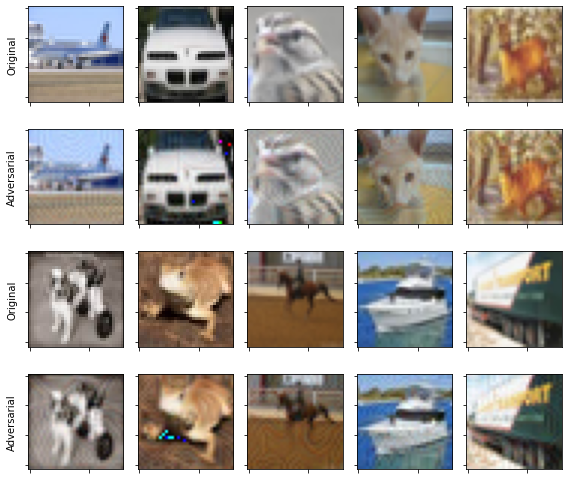

In [11]:
compare()